In [34]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model
import torch
import torch.nn.functional as F
import torch.nn as nn

# Upload tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [36]:

# Load pre-trained GPT-2 (small version)
model = GPT2Model.from_pretrained("gpt2")

# Choose a layer index (e.g., 0 for the first transformer block)
layer_idx = 11

# Extract the FFNN (MLP) from the transformer block
ffnn = model.h[layer_idx].mlp

# Print the structure
print(ffnn)



GPT2MLP(
  (c_fc): Conv1D(nf=3072, nx=768)
  (c_proj): Conv1D(nf=768, nx=3072)
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [102]:
# Extract weights and biases from the Conv1D layers
def convert_conv1d_to_linear(conv1d):
    # Conv1D in GPT-2 uses weight of shape (out_features, in_features)
    weight = conv1d.weight.T  # Shape: [in_features, out_features]
    bias = conv1d.bias
    return nn.Linear(weight.shape[0], weight.shape[1], bias=True).to(weight.device).load_state_dict({
        'weight': weight.T,
        'bias': bias
    }, strict=True)

# Extract components
fc1 = model.h[layer_idx].mlp.c_fc
proj = model.h[layer_idx].mlp.c_proj
act = model.h[layer_idx].mlp.act  # NewGELUActivation

# Recreate the FFNN as a PyTorch module
class GPT2FFNN(nn.Module):
    def __init__(self, fc1, proj, act):
        super().__init__()
        self.fc1 = nn.Linear(fc1.weight.shape[1], fc1.weight.shape[0])
        self.proj = nn.Linear(proj.weight.shape[1], proj.weight.shape[0])
        self.act = act  # This is already a module

        # Load weights
        self.fc1.weight.data = fc1.weight.T.clone()
        self.fc1.bias.data = fc1.bias.clone()
        self.fc1.bias.data = torch.zeros_like(fc1.bias)
        self.proj.weight.data = proj.weight.T.clone()
        self.proj.bias.data = proj.bias.clone()
        self.proj.bias.data = torch.zeros_like(proj.bias)

    def forward(self, x):
        return self.proj(self.act(self.fc1(x)))

# Instantiate
ffnn_reconstructed = GPT2FFNN(fc1, proj, act)



Values visualization and normalization

In [103]:
#x = torch.randn(1, 768)  # corresponds to [batch_size, hidden_size]

# Create a vector of zeros
x = torch.zeros(768)

# Set elements 64 to 127 to 1 (second head block)
k=11
x[k*64:k*64+64] = 1.0

# Add batch dimension: [1, 768]
x = x.unsqueeze(0)

# Pass through FFNN
output = ffnn_reconstructed(x)

print(x.shape, output.shape)  # Should be [1, 768]
print(x[0][:3])
print(output[0][:3])
#print(output[0])
print(sum(x[0]), sum(output[0]), "\n")

sx = []
so = []
    
for k in range(12):
    x = torch.zeros(768)
    x[k*64:k*64+64] = 1.0
    x = x.unsqueeze(0)
    output = ffnn_reconstructed(x)
    print(k, sum(x[0]), sum(output[0]))
    sx.append(sum(x[0]))
    so.append(sum(output[0]))

print("\n", sum(sx), sum(so))


torch.Size([1, 768]) torch.Size([1, 768])
tensor([0., 0., 0.])
tensor([-5.5697,  0.3439,  5.3088], grad_fn=<SliceBackward0>)
tensor(64.) tensor(-42.4882, grad_fn=<AddBackward0>) 

0 tensor(64.) tensor(-16.2466, grad_fn=<AddBackward0>)
1 tensor(64.) tensor(-125.5241, grad_fn=<AddBackward0>)
2 tensor(64.) tensor(-69.8969, grad_fn=<AddBackward0>)
3 tensor(64.) tensor(-64.4926, grad_fn=<AddBackward0>)
4 tensor(64.) tensor(-99.5962, grad_fn=<AddBackward0>)
5 tensor(64.) tensor(90.4113, grad_fn=<AddBackward0>)
6 tensor(64.) tensor(1.1919, grad_fn=<AddBackward0>)
7 tensor(64.) tensor(74.4619, grad_fn=<AddBackward0>)
8 tensor(64.) tensor(-7.0269, grad_fn=<AddBackward0>)
9 tensor(64.) tensor(-170.1499, grad_fn=<AddBackward0>)
10 tensor(64.) tensor(-107.9790, grad_fn=<AddBackward0>)
11 tensor(64.) tensor(-42.4882, grad_fn=<AddBackward0>)

 tensor(768.) tensor(-537.3352, grad_fn=<AddBackward0>)


Colour Visualization

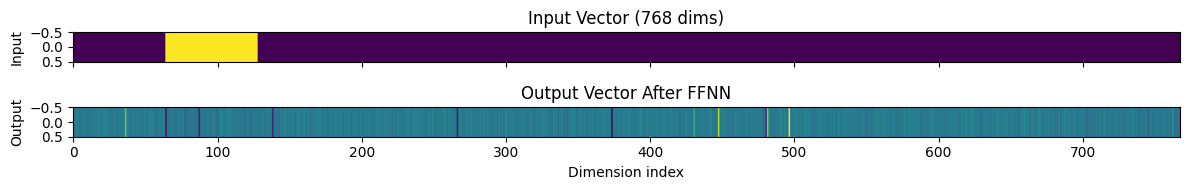

In [105]:
# Create your input vector
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)

# Get output from FFNN
with torch.no_grad():
    output = ffnn_reconstructed(x)

# Remove batch dimension
x_np = x.squeeze(0).numpy()
out_np = output.squeeze(0).numpy()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

# Input heatmap
ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[0].set_title("Input Vector (768 dims)")
ax[0].set_ylabel("Input")

# Output heatmap
ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[1].set_title("Output Vector After FFNN")
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Dimension index")
plt.tight_layout()
plt.show()


In [ ]:
# to understand what is the bias, and maybe visualize it or actually remove it

# caregul about the bias, remove it


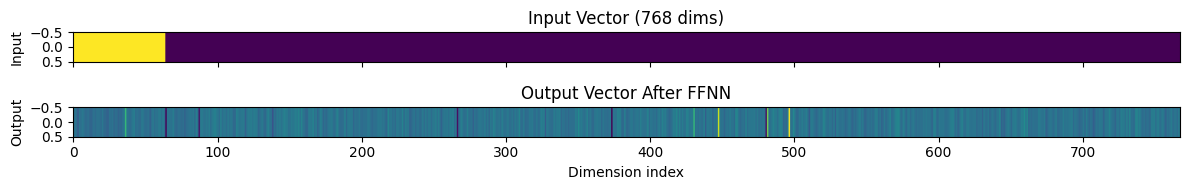

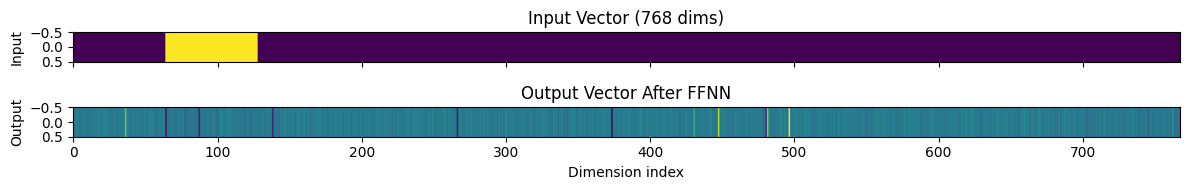

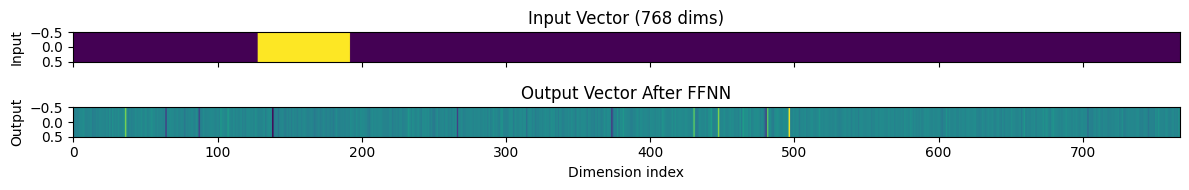

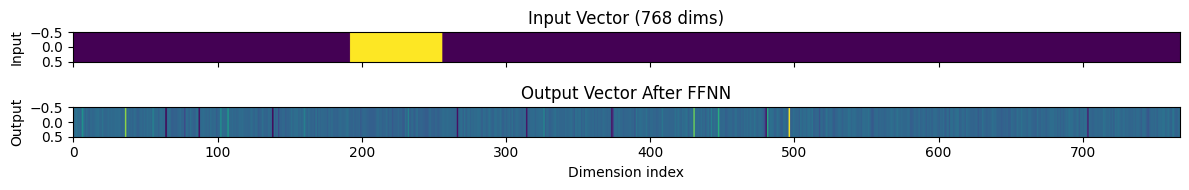

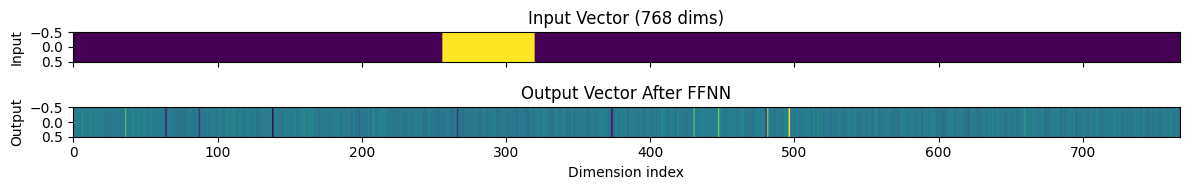

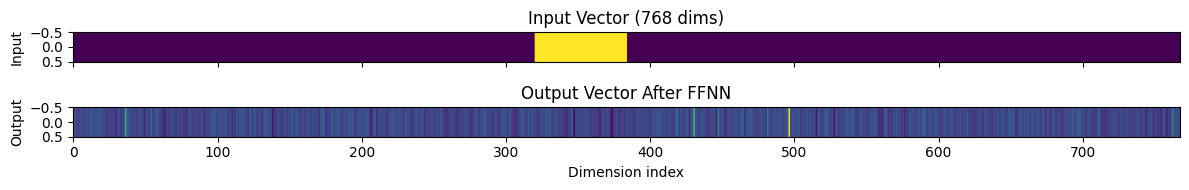

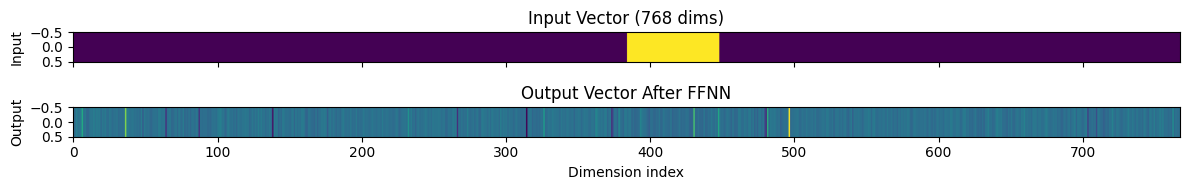

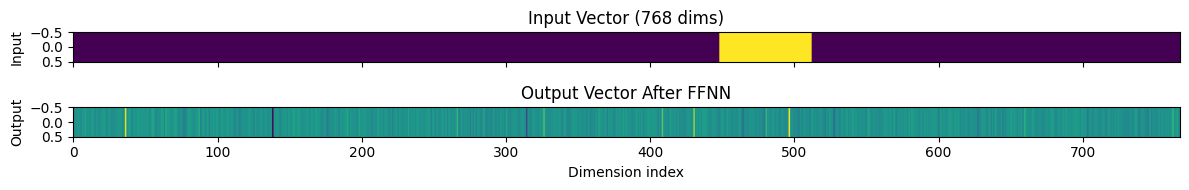

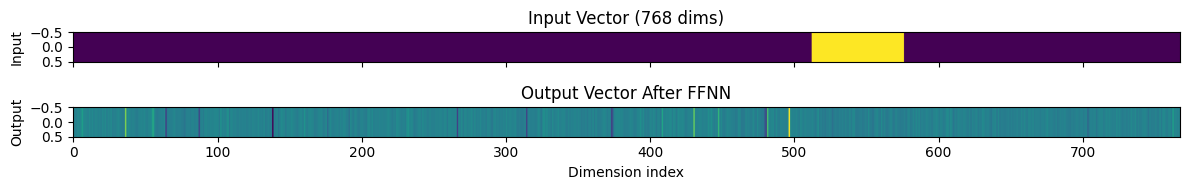

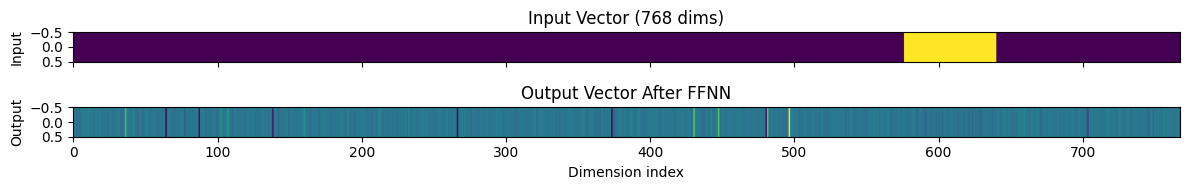

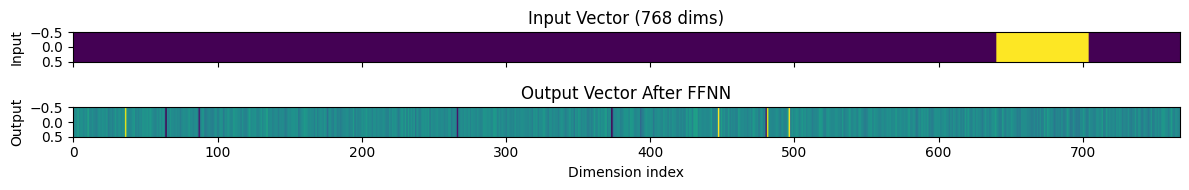

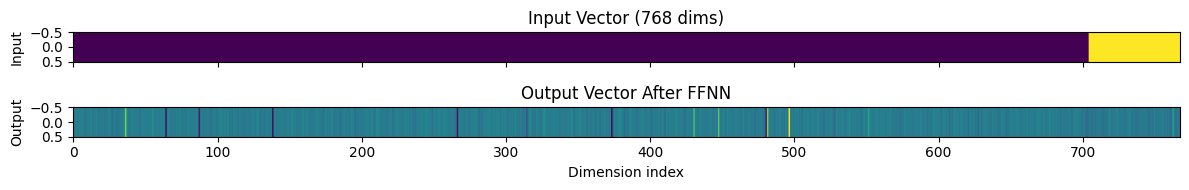

(768,)


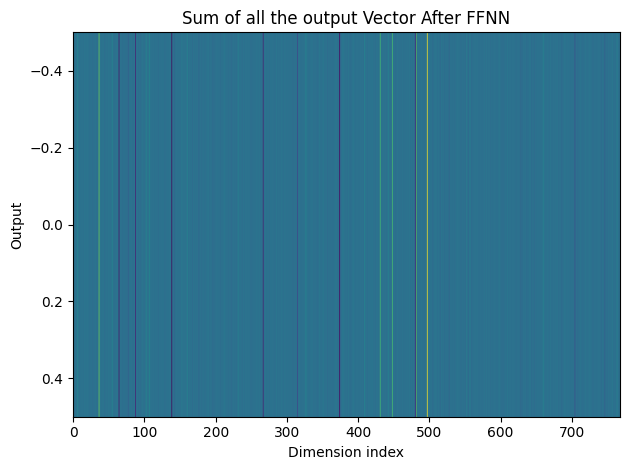

In [106]:
sum_out = []
for k in range(12):
    # Create your input vector
    x = torch.zeros(768)
    x[k*64:k*64 + 64] = 1.0
    x = x.unsqueeze(0)

    # Get output from FFNN
    with torch.no_grad():
        output = ffnn_reconstructed(x)

    # Remove batch dimension
    x_np = x.squeeze(0).numpy()
    out_np = output.squeeze(0).numpy()
    sum_out.append(out_np)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

    # Input heatmap
    ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[0].set_title("Input Vector (768 dims)")
    ax[0].set_ylabel("Input")

    # Output heatmap
    ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[1].set_title("Output Vector After FFNN")
    ax[1].set_ylabel("Output")
    ax[1].set_xlabel("Dimension index")
    plt.tight_layout()
    plt.show()

# sum the elements inside the output vector
total_sum = np.sum(sum_out, axis=0)
print(total_sum.shape)

# Plotting
figsize=(12, 2)

# Output heatmap
plt.imshow(total_sum[np.newaxis, :], cmap='viridis', aspect='auto')
plt.title("Sum of all the output Vector After FFNN")
plt.ylabel("Output")
plt.xlabel("Dimension index")
plt.tight_layout()
plt.show()


In [82]:

# Verify if the sum of the output vector is equal to the sum of the input vector
print("Sum of input vector:", sum(sx))
print("Sum of output vector:", np.sum(total_sum))


Sum of input vector: tensor(768.)
Sum of output vector: -537.3346


In [83]:
# find the x that cancels the Wx + b inside the gelu


## Layer normalization
We now perform an analysis over the normalization and residual sum of the model over the layers

In [84]:
block = model.h[layer_idx]

print(block)


GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D(nf=2304, nx=768)
    (c_proj): Conv1D(nf=768, nx=768)
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D(nf=3072, nx=768)
    (c_proj): Conv1D(nf=768, nx=3072)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [85]:
def simplified_block_forward(x):
    # Attention with residual
    attn_out = block.attn(block.ln_1(x))[0]
    x = x + attn_out
    
    # FFNN with residual
    ffnn_out = block.mlp(block.ln_2(x))
    x = x + ffnn_out
    
    return x


In [86]:
x_input = torch.randn(1, 768)

# Forward through FFNN
x_ln = block.ln_2(x_input)
ffnn_out = block.mlp(x_ln)

# Residual connection
x_res = x_input + ffnn_out

# Final output (LayerNorm can be applied here if you're mimicking post-LN style)


### Direct comparison between the two approaches

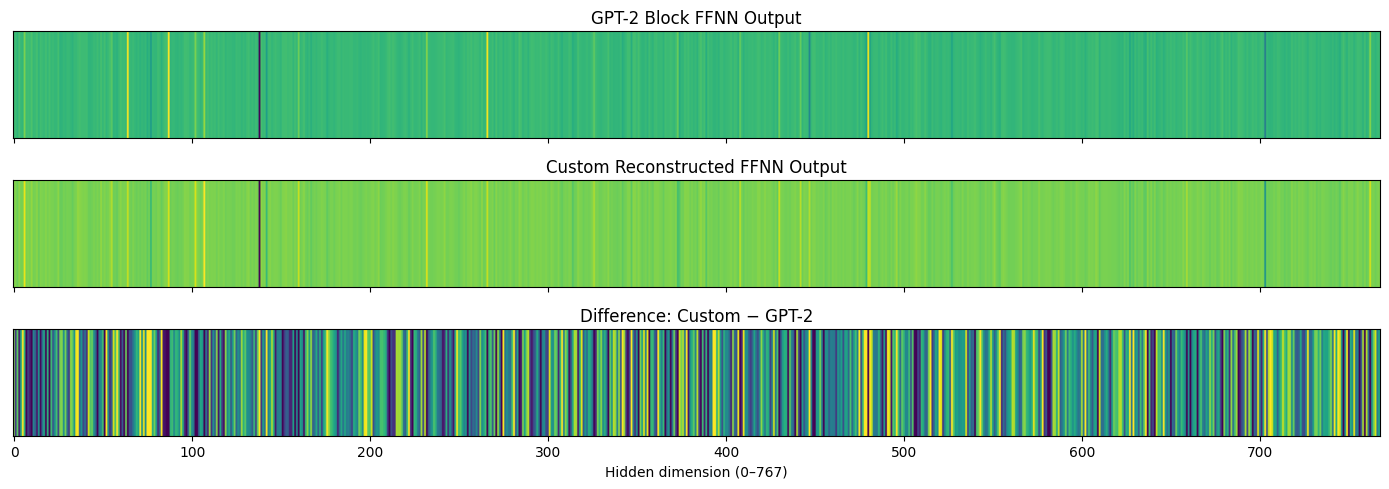

difference: 28.98439 -24.15061 

gpt2 original: 34.714424 -71.411385 

custom without the biases: 16.521563 -64.58483 



In [ ]:
# 1. Choose a GPT-2 block
block = model.h[layer_idx]

# 2. Input vector (structured or random)
x = torch.zeros(768)
x[64:128] = 0.0001
x = x.unsqueeze(0)  # shape: [1, 768]
x_input = x

#x_input = torch.randn(1, 768)

# 3. Normalize input
x_normed = block.ln_2(x_input)

# 4. FFNN through GPT-2
with torch.no_grad():
    ffnn_out_gpt2 = block.mlp(x_normed)

# 5. FFNN through your custom reconstructed version
with torch.no_grad():
    ffnn_out_custom = ffnn_reconstructed(x_normed)

# 6. Difference between the two
diff = (ffnn_out_custom - ffnn_out_gpt2).squeeze(0).numpy()

# 7. Convert all to numpy for heatmaps
gpt2_np = ffnn_out_gpt2.squeeze(0).numpy()
custom_np = ffnn_out_custom.squeeze(0).numpy()

# 8. Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(14, 5), sharex=True)

# Original GPT-2 FFNN
axes[0].imshow(gpt2_np[np.newaxis, :], cmap='viridis', aspect='auto')
axes[0].set_title("GPT-2 Block FFNN Output")

# Reconstructed FFNN
axes[1].imshow(custom_np[np.newaxis, :], cmap='viridis', aspect='auto')
axes[1].set_title("Custom Reconstructed FFNN Output")

# Difference
axes[2].imshow(diff[np.newaxis, :], cmap='viridis', aspect='auto', vmin=-1, vmax=1)
axes[2].set_title("Difference: Custom − GPT-2")
axes[2].set_xlabel("Hidden dimension (0–767)")

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()
plt.show()

print("difference:", max(diff), min(diff), "\n")
print("gpt2 original:", max(gpt2_np),  min(gpt2_np), "\n")
print("custom without the biases:", max(custom_np),  min(custom_np), "\n")


In [ ]:
# The biases doesn't matter really much could it be that the values in inputs in the buffer are too high?


In [ ]:
# Always include the colourbar besides the maps to understand the range


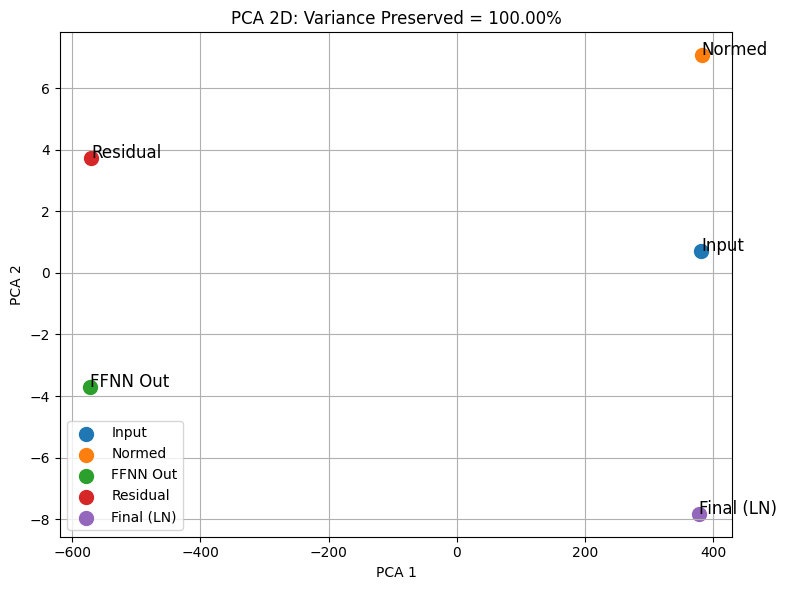

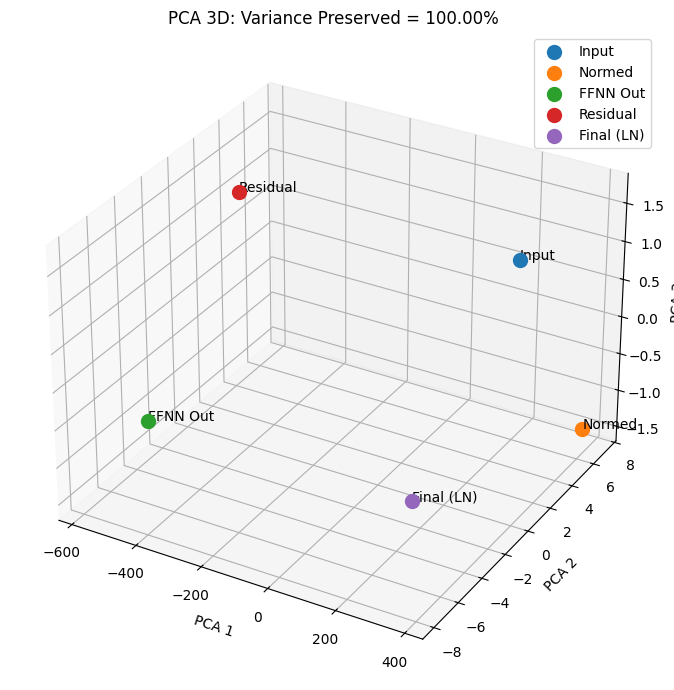

[PCA 2D] Variance preserved: 1.0000 → Info loss: 0.0000
[PCA 3D] Variance preserved: 1.0000 → Info loss: 0.0000


In [46]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Choose transformer block
block = model.h[layer_idx]

# Create structured input (second attention head activated)
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)  # [1, 768]

# Transformations through block
with torch.no_grad():
    x_normed = block.ln_2(x)
    ffnn_out = block.mlp(x_normed)
    x_residual = x + ffnn_out
    x_final = block.ln_2(x_residual)

# Stack all vectors
vectors = torch.cat([x, x_normed, ffnn_out, x_residual, x_final], dim=0).numpy()
labels = ["Input", "Normed", "FFNN Out", "Residual", "Final (LN)"]

# === PCA 2D ===
pca_2d = PCA(n_components=2)
proj_2d = pca_2d.fit_transform(vectors)
explained_2d = np.sum(pca_2d.explained_variance_ratio_)

# === PCA 3D ===
pca_3d = PCA(n_components=3)
proj_3d = pca_3d.fit_transform(vectors)
explained_3d = np.sum(pca_3d.explained_variance_ratio_)

# === Plot 2D ===
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(proj_2d[i, 0], proj_2d[i, 1], label=label, s=100)
    plt.text(proj_2d[i, 0]+0.1, proj_2d[i, 1], label, fontsize=12)

plt.title(f"PCA 2D: Variance Preserved = {explained_2d:.2%}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3D ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(labels):
    ax.scatter(proj_3d[i, 0], proj_3d[i, 1], proj_3d[i, 2], label=label, s=100)
    ax.text(proj_3d[i, 0], proj_3d[i, 1], proj_3d[i, 2], label)

ax.set_title(f"PCA 3D: Variance Preserved = {explained_3d:.2%}")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.legend()
plt.tight_layout()
plt.show()

# === Report variance loss ===
print(f"[PCA 2D] Variance preserved: {explained_2d:.4f} → Info loss: {1 - explained_2d:.4f}")
print(f"[PCA 3D] Variance preserved: {explained_3d:.4f} → Info loss: {1 - explained_3d:.4f}")


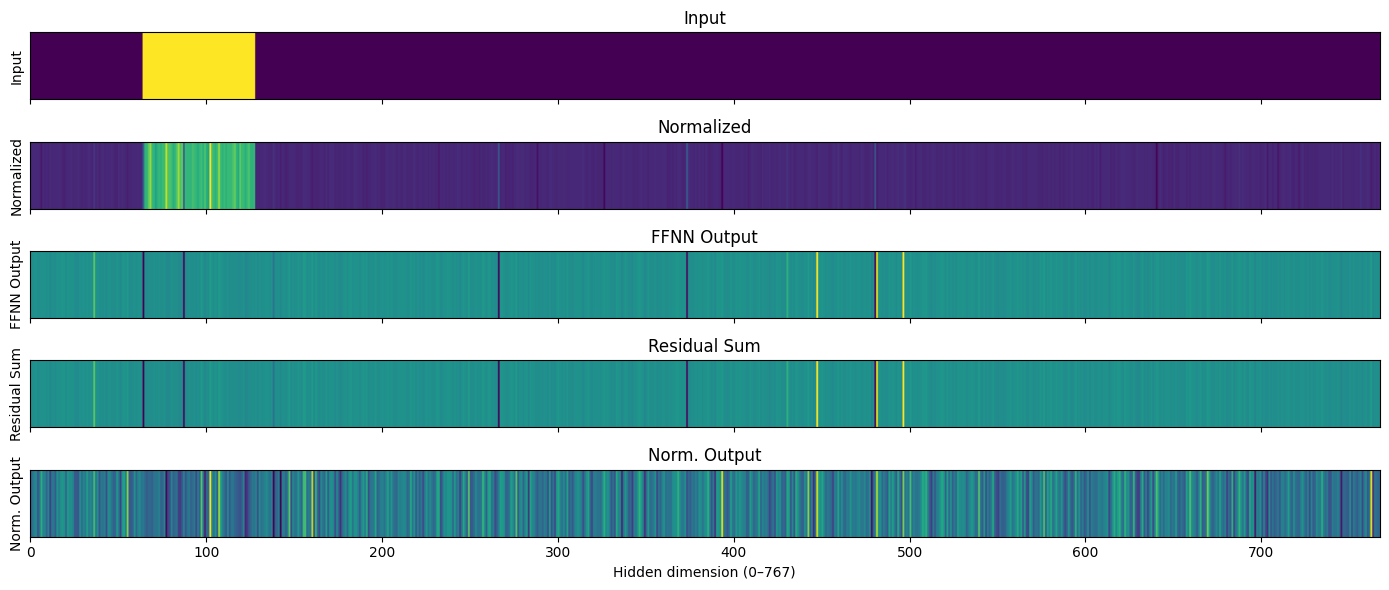

Sum of elements in normalized vector (Normalized and Norm. Output): 5.980797 15.892489


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Choose a transformer block
block = model.h[layer_idx]

# Create input vector: activate second attention head
x = torch.zeros(1, 768)
x[0, 64:128] = 1.0  # shape [1, 768]

with torch.no_grad():
    # Normalize input before FFNN
    x_normed = block.ln_2(x)

    # FFNN output
    ffnn_out = block.mlp(x_normed)

    # Residual sum
    x_residual = x + ffnn_out

    # Final output after residual + LayerNorm
    x_final = block.ln_2(x_residual)

# Convert to numpy for plotting
vectors = [
    x.squeeze(0).numpy(),
    x_normed.squeeze(0).numpy(),
    ffnn_out.squeeze(0).numpy(),
    x_residual.squeeze(0).numpy(),
    x_final.squeeze(0).numpy()
]
titles = ["Input", "Normalized", "FFNN Output", "Residual Sum", "Norm. Output"]

# Plot heatmaps
fig, axes = plt.subplots(len(vectors), 1, figsize=(14, 6), sharex=True)

for i, (vec, title) in enumerate(zip(vectors, titles)):
    axes[i].imshow(vec[np.newaxis, :], cmap='viridis', aspect='auto')
    axes[i].set_title(title)
    axes[i].set_ylabel(title)
    axes[i].set_yticks([])

axes[-1].set_xlabel("Hidden dimension (0–767)")
plt.tight_layout()
plt.show()

# sum the values of the elements inside the output vector
print("Sum of elements in normalized vector (Normalized and Norm. Output):", np.sum(vectors[1]), np.sum(vectors[-1]))


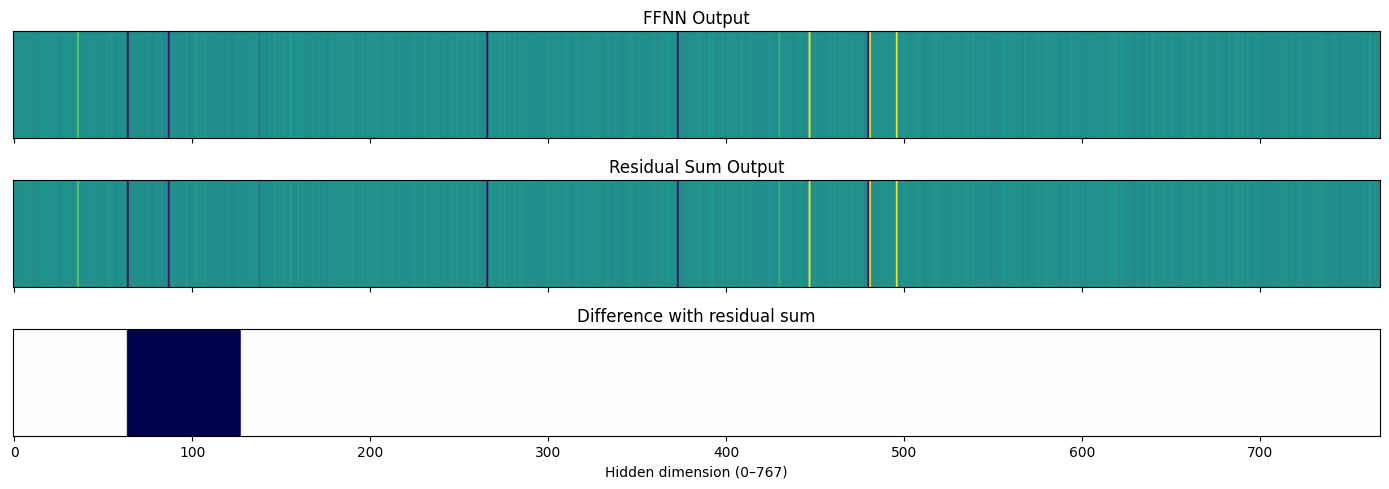

In [ ]:
# Verify that the Residual sum is actually different from the FFNN output

# Difference between the two
diff = (ffnn_out - x_residual).squeeze(0).numpy()

# Convert all to numpy for heatmaps
ffnn = vectors[2]
rs = vectors[3]

# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(14, 5), sharex=True)

# Original GPT-2 FFNN
axes[0].imshow(ffnn[np.newaxis, :], cmap='viridis', aspect='auto')
axes[0].set_title("FFNN Output")

# Reconstructed FFNN
axes[1].imshow(rs[np.newaxis, :], cmap='viridis', aspect='auto')
axes[1].set_title("Residual Sum Output")

# Difference
axes[2].imshow(diff[np.newaxis, :], cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axes[2].set_title("Difference with residual sum")
axes[2].set_xlabel("Hidden dimension (0–767)")

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Now we perform the analysis over different layers to verify if the FFNN behaves differently:

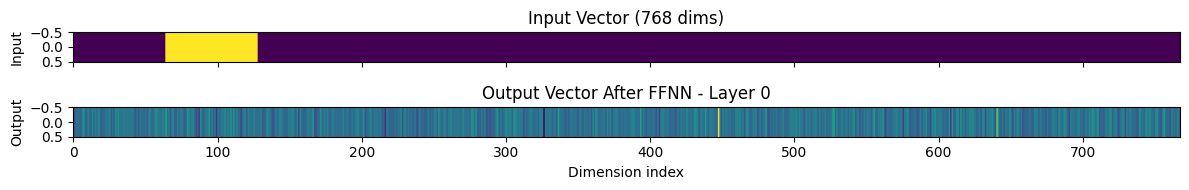

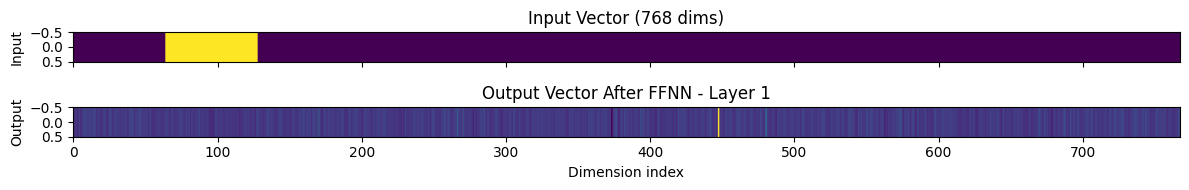

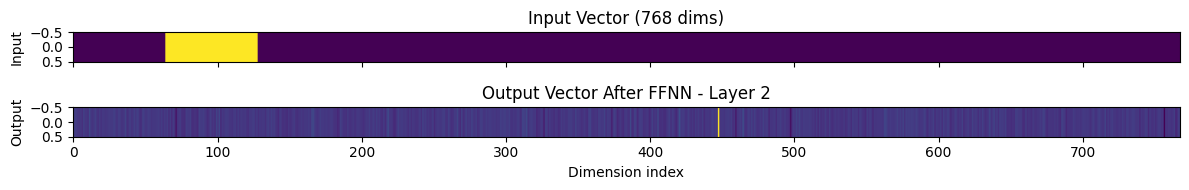

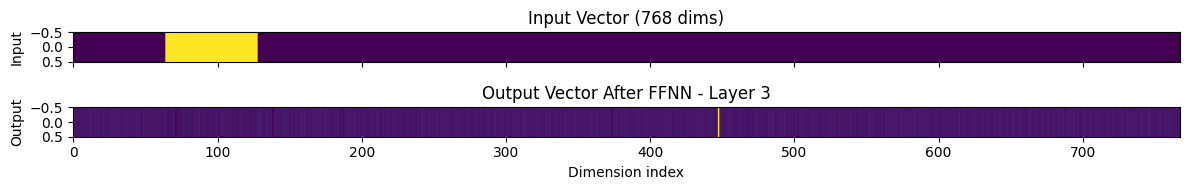

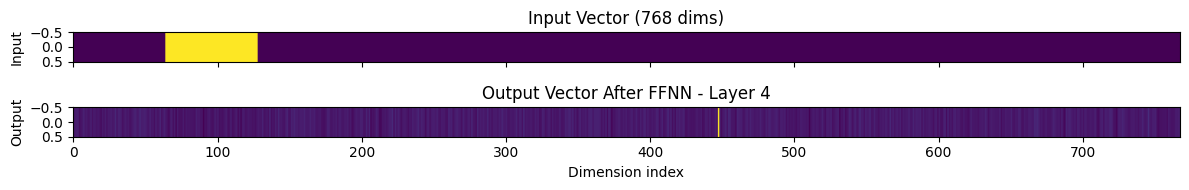

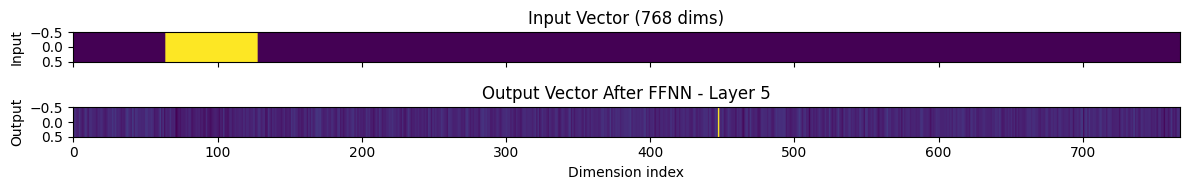

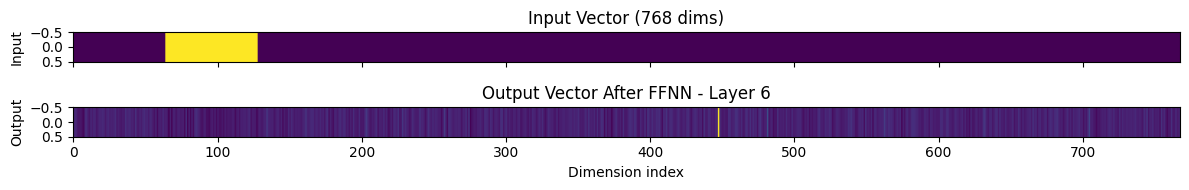

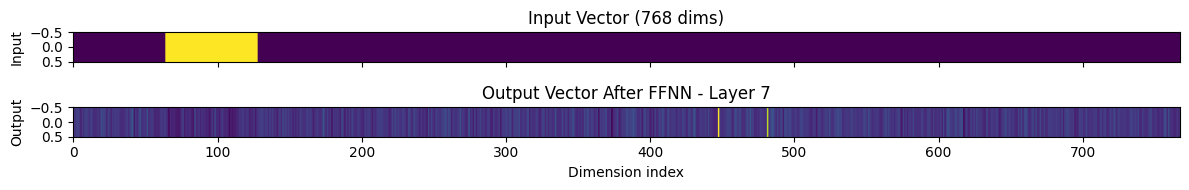

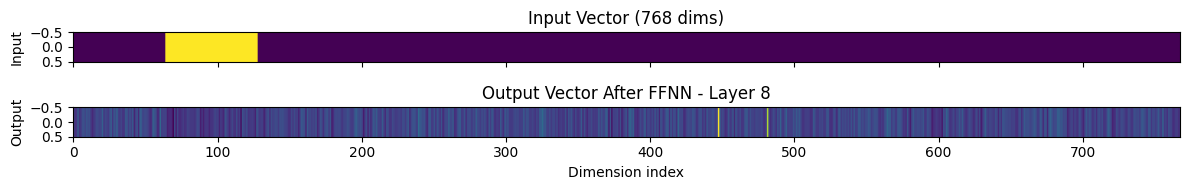

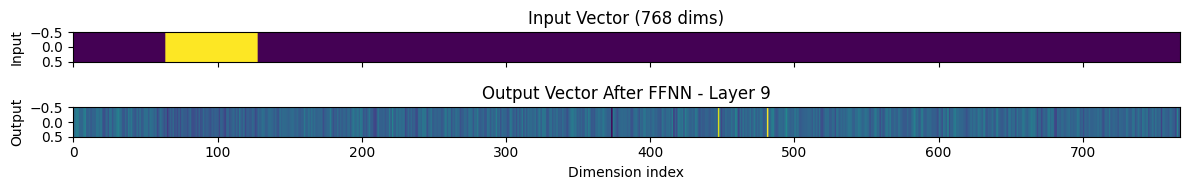

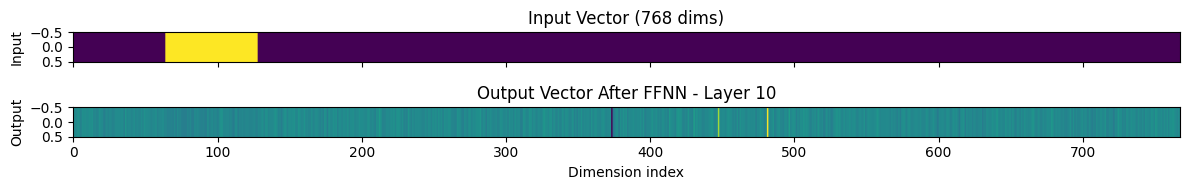

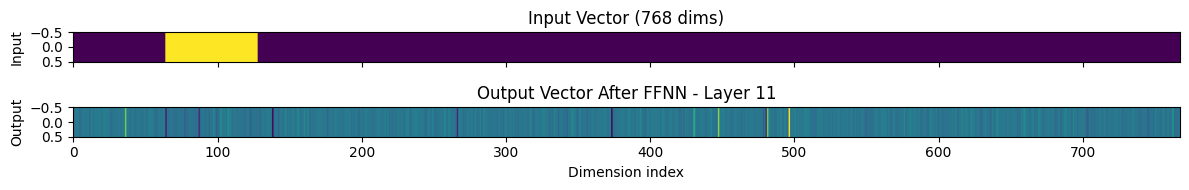

In [51]:
for id in range(12):
    # Choose transformer block
    block = model.h[id]

    # Create structured input (second attention head activated)
    x = torch.zeros(768)
    x[64:128] = 1.0
    x = x.unsqueeze(0)  # [1, 768]

    # Get output from FFNN
    with torch.no_grad():
        output = block.mlp(x)

    # Remove batch dimension
    x_np = x.squeeze(0).numpy()
    out_np = output.squeeze(0).numpy()

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

    # Input heatmap
    ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[0].set_title("Input Vector (768 dims)")
    ax[0].set_ylabel("Input")

    # Output heatmap
    ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
    ax[1].set_title(f"Output Vector After FFNN - Layer {id}")
    ax[1].set_ylabel("Output")
    ax[1].set_xlabel("Dimension index")
    plt.tight_layout()
    plt.show()


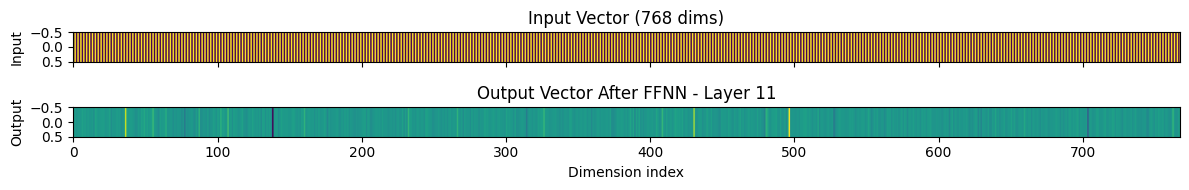

In [96]:
 # Choose transformer block
block = model.h[id]

# Create structured input (second attention head activated)
x = torch.ones(768)
for i in range(768):
    if(i%2==0):
        x[i] = 0.0
x = x.unsqueeze(0)  # [1, 768]

# Get output from FFNN
with torch.no_grad():
    output = block.mlp(x)

# Remove batch dimension
x_np = x.squeeze(0).numpy()
out_np = output.squeeze(0).numpy()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True)

# Input heatmap
ax[0].imshow(x_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[0].set_title("Input Vector (768 dims)")
ax[0].set_ylabel("Input")

# Output heatmap
ax[1].imshow(out_np[np.newaxis, :], cmap='viridis', aspect='auto')
ax[1].set_title(f"Output Vector After FFNN - Layer {id}")
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Dimension index")
plt.tight_layout()
plt.show()


### FFNN Neurons activation

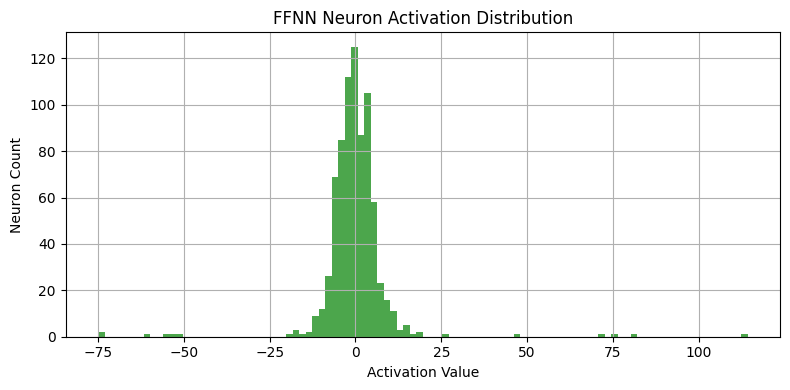

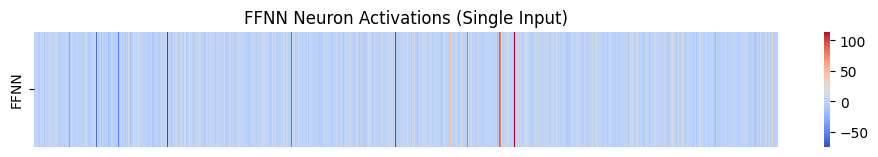

Active neurons: 768 / 768 → Sparsity: 0.00%


In [95]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose your GPT-2 block
block = model.h[layer_idx]

# Create a structured input (activating head 1)
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)

# FFNN pass
with torch.no_grad():
    #x_ln = block.ln_2(x)
    x_ln = x
    ffnn_out = block.mlp(x_ln)

# Convert to numpy
ffnn_out_np = ffnn_out.squeeze().cpu().numpy()

# === Activation Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(ffnn_out_np, bins=100, color="green", alpha=0.7)
plt.title("FFNN Neuron Activation Distribution")
plt.xlabel("Activation Value")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Activation Heatmap ===
plt.figure(figsize=(12, 1.5))
sns.heatmap(ffnn_out_np.reshape(1, -1), cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=["FFNN"])
plt.title("FFNN Neuron Activations (Single Input)")
plt.show()

# === Sparsity Metric ===
num_nonzero = np.sum(np.abs(ffnn_out_np) > 1e-3)
print(f"Active neurons: {num_nonzero} / {len(ffnn_out_np)} → Sparsity: {1 - num_nonzero / len(ffnn_out_np):.2%}")


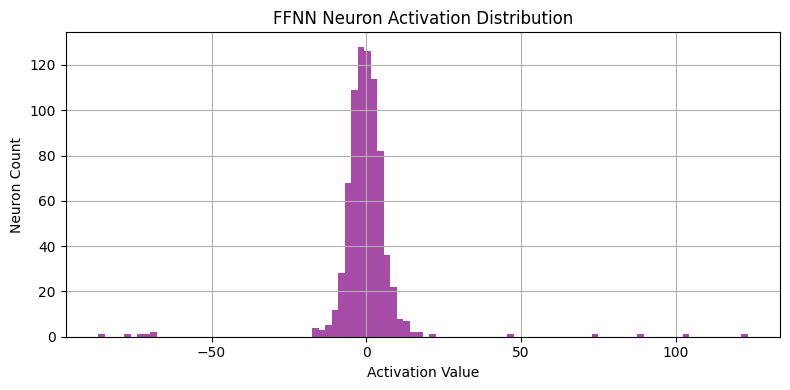

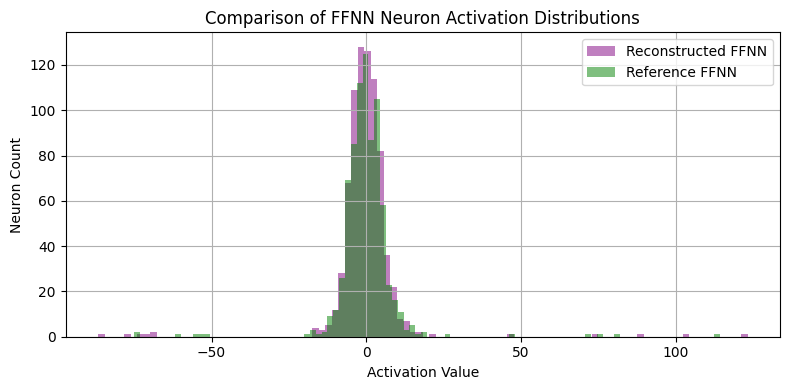

Active neurons: 768 / 768 → Sparsity: 0.00%


In [94]:
# Create your input vector
x = torch.zeros(768)
x[64:128] = 1.0
x = x.unsqueeze(0)

# Get output from FFNN
with torch.no_grad():
    output = ffnn_reconstructed(x)

# Remove batch dimension
x_np = x.squeeze(0).numpy()
out_np = output.squeeze(0).numpy()

# === Activation Histogram ===
plt.figure(figsize=(8, 4))
plt.hist(out_np, bins=100, color="purple", alpha=0.7)
plt.title("FFNN Neuron Activation Distribution")
plt.xlabel("Activation Value")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram comparing out_np (reconstructed FFNN) and ffnn_out_np (reference)
plt.figure(figsize=(8, 4))
plt.hist(out_np, bins=100, color="purple", alpha=0.5, label="Reconstructed FFNN")
plt.hist(ffnn_out_np, bins=100, color="green", alpha=0.5, label="Reference FFNN")
plt.title("Comparison of FFNN Neuron Activation Distributions")
plt.xlabel("Activation Value")
plt.ylabel("Neuron Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sparsity Metric ===
num_nonzero = np.sum(np.abs(ffnn_out_np) > 1e-3)
print(f"Active neurons: {num_nonzero} / {len(ffnn_out_np)} → Sparsity: {1 - num_nonzero / len(ffnn_out_np):.2%}")


In [ ]:
# COmpare this to the result I obtain with the bias


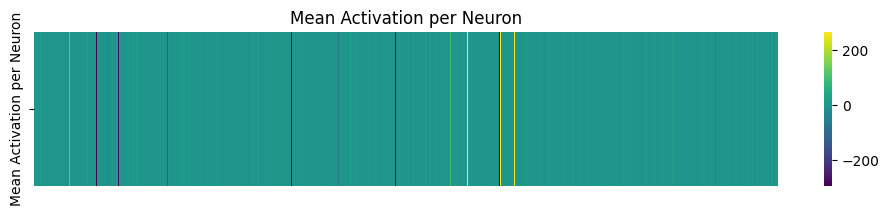

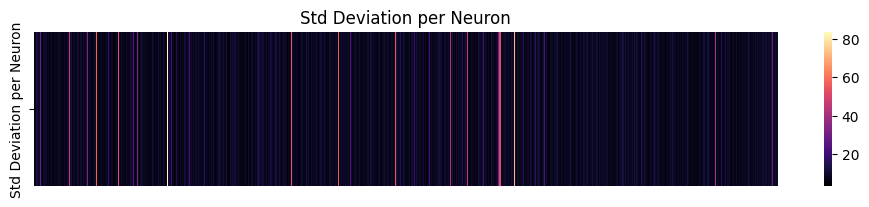

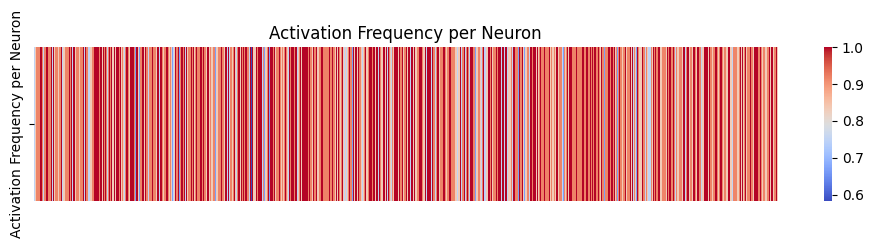

In [60]:

# Build batch of 12 structured vectors (activate each attention head output)
batch = []
for i in range(12):
    x = torch.zeros(768)
    x[i*64:(i+1)*64] = 1.0
    batch.append(x)

x_batch = torch.stack(batch)

# Pass through FFNN
with torch.no_grad():
    x_ln = block.ln_2(x_batch)
    ffnn_hid = block.mlp(x_ln).numpy()  # shape: [12, 3072]

# Calculate statistics
mean_act = np.mean(ffnn_hid, axis=0)
std_act = np.std(ffnn_hid, axis=0)
freq_act = np.sum(np.abs(ffnn_hid) > 1, axis=0) / ffnn_hid.shape[0]

# Plot
def plot_stat(stat, title, cmap="viridis"):
    plt.figure(figsize=(12, 2))
    sns.heatmap(stat.reshape(1, -1), cmap=cmap, cbar=True, xticklabels=False, yticklabels=[title])
    plt.title(title)
    plt.show()

plot_stat(mean_act, "Mean Activation per Neuron")
plot_stat(std_act, "Std Deviation per Neuron", cmap="magma")
plot_stat(freq_act, "Activation Frequency per Neuron", cmap="coolwarm")


In [ ]:
# study the up projection of the W1 and how the neurons are activated
# after this how the W2 are being activated strating from the hidden layer

# canonical decomposition to see if it destroys information
# study W2 and see how many dimensions does it take down
# if it really goes to RD or to a smaller dimension Rd


# description of the entropy of mixing
# the ability of this system to shuffle this system around
